In [1]:
import numpy as np
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
# import torch
# from torch import nn  

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray 

In [3]:
plt.rcParams['font.size'] = '6'

In [4]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000s_testNNdev_stellarcpu_intelmpi_22_768PE/'
  
# ds = xr.open_dataset(file_path+'/HISTORY/20000101.atmos_8xdaily.tile2.nc')  
ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 
ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})

In [5]:
def plot_var12_diff(var1):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    level = np.arange(0,400,10)
    for i in range(2):
        ax=axs[i]
        da = ds[var1[i]][1:-1].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        # ax.set_title(f'{var1[i]} GM: {da.mean().values:4.2f}')  
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    level = np.arange(-20,20,2)
    da = (ds[var1[0]].mean('time')-ds[var1[1]].mean('time'))
    da.plot(ax=ax, levels=level, extend='both') 
    ax.set_title(f'diff GM: {da.mean().values:4.2f}')  
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

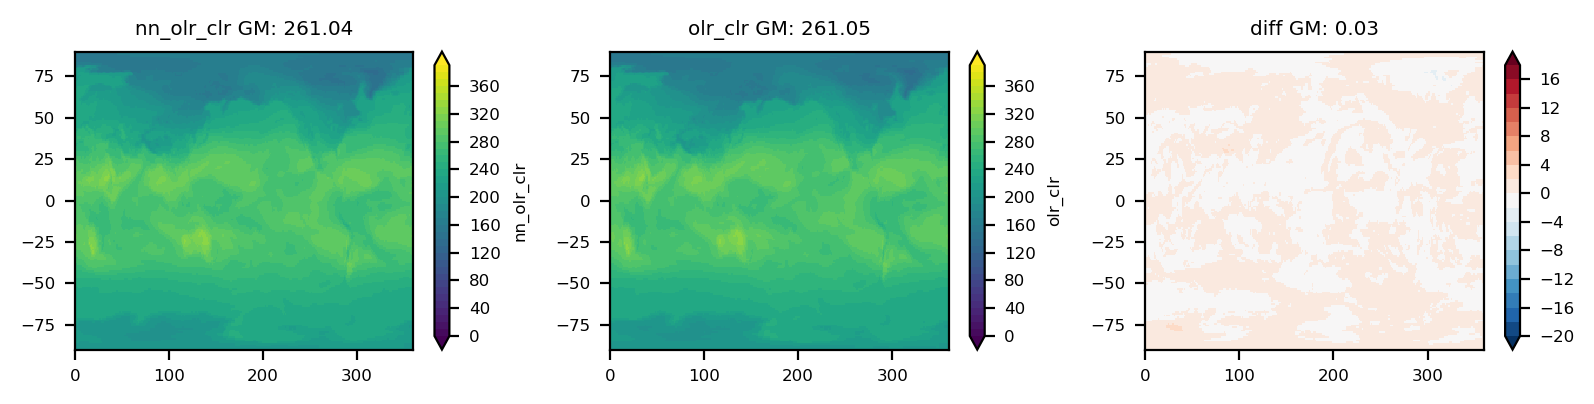

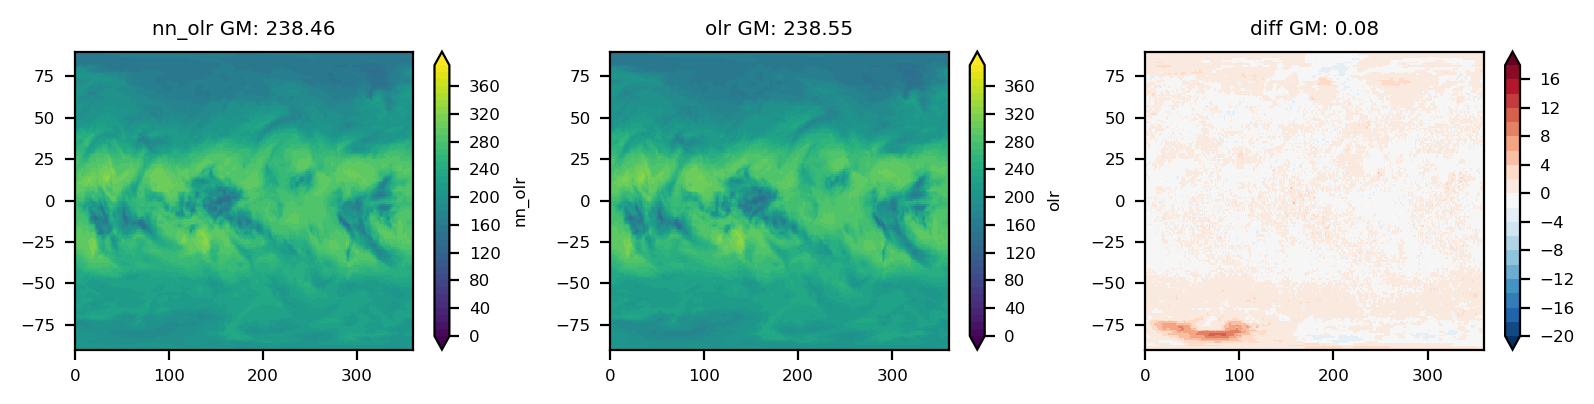

In [6]:
var = ['nn_olr_clr','olr_clr',]
plot_var12_diff(var)

var = ['nn_olr','olr',]
plot_var12_diff(var)

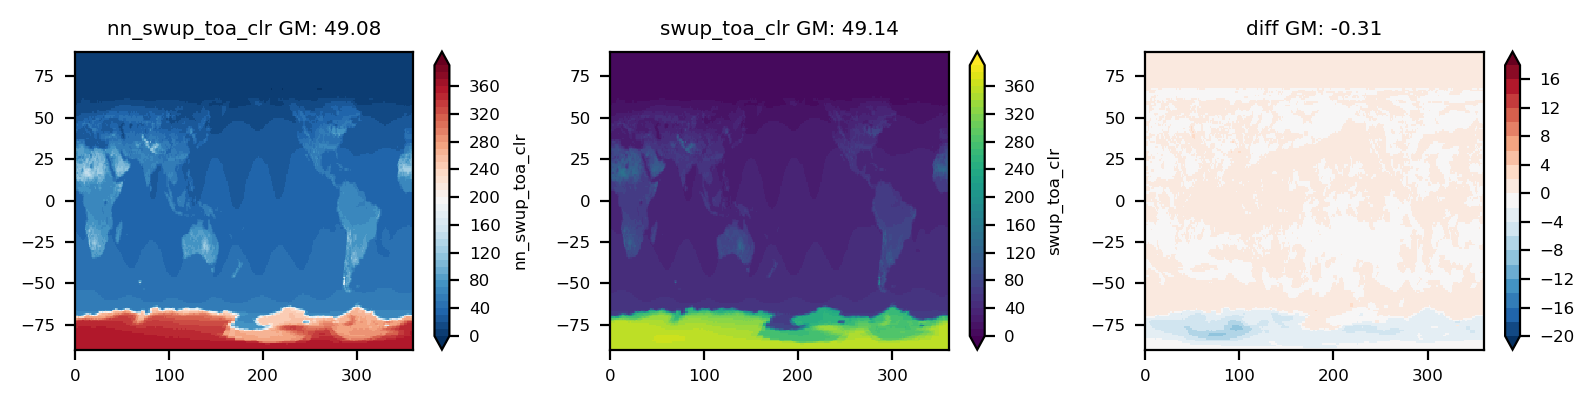

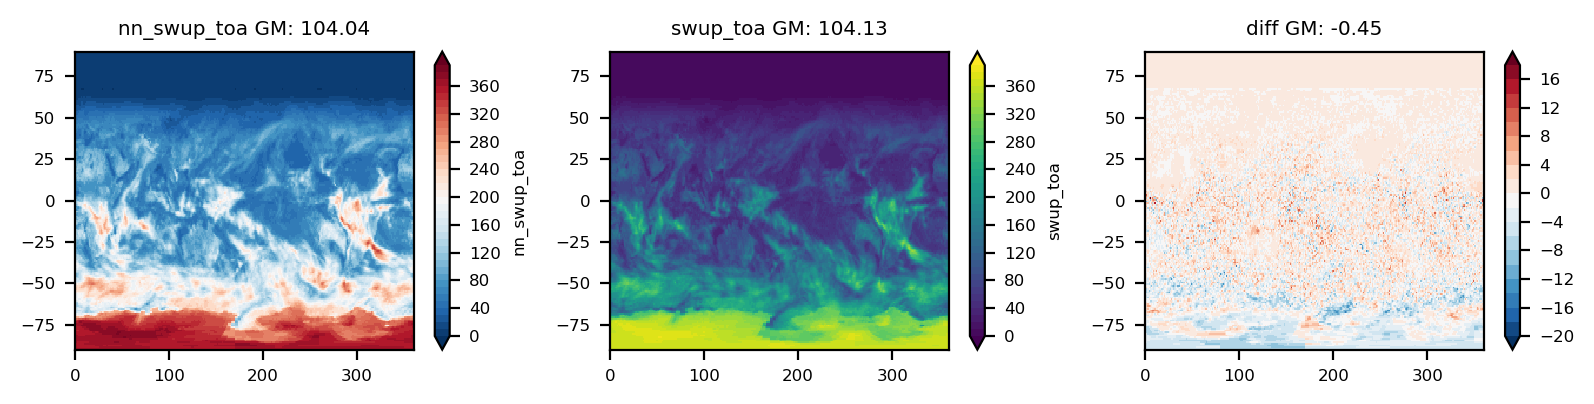

In [7]:
var = ['nn_swup_toa_clr','swup_toa_clr',]
plot_var12_diff(var)
var = ['nn_swup_toa','swup_toa',]
plot_var12_diff(var)

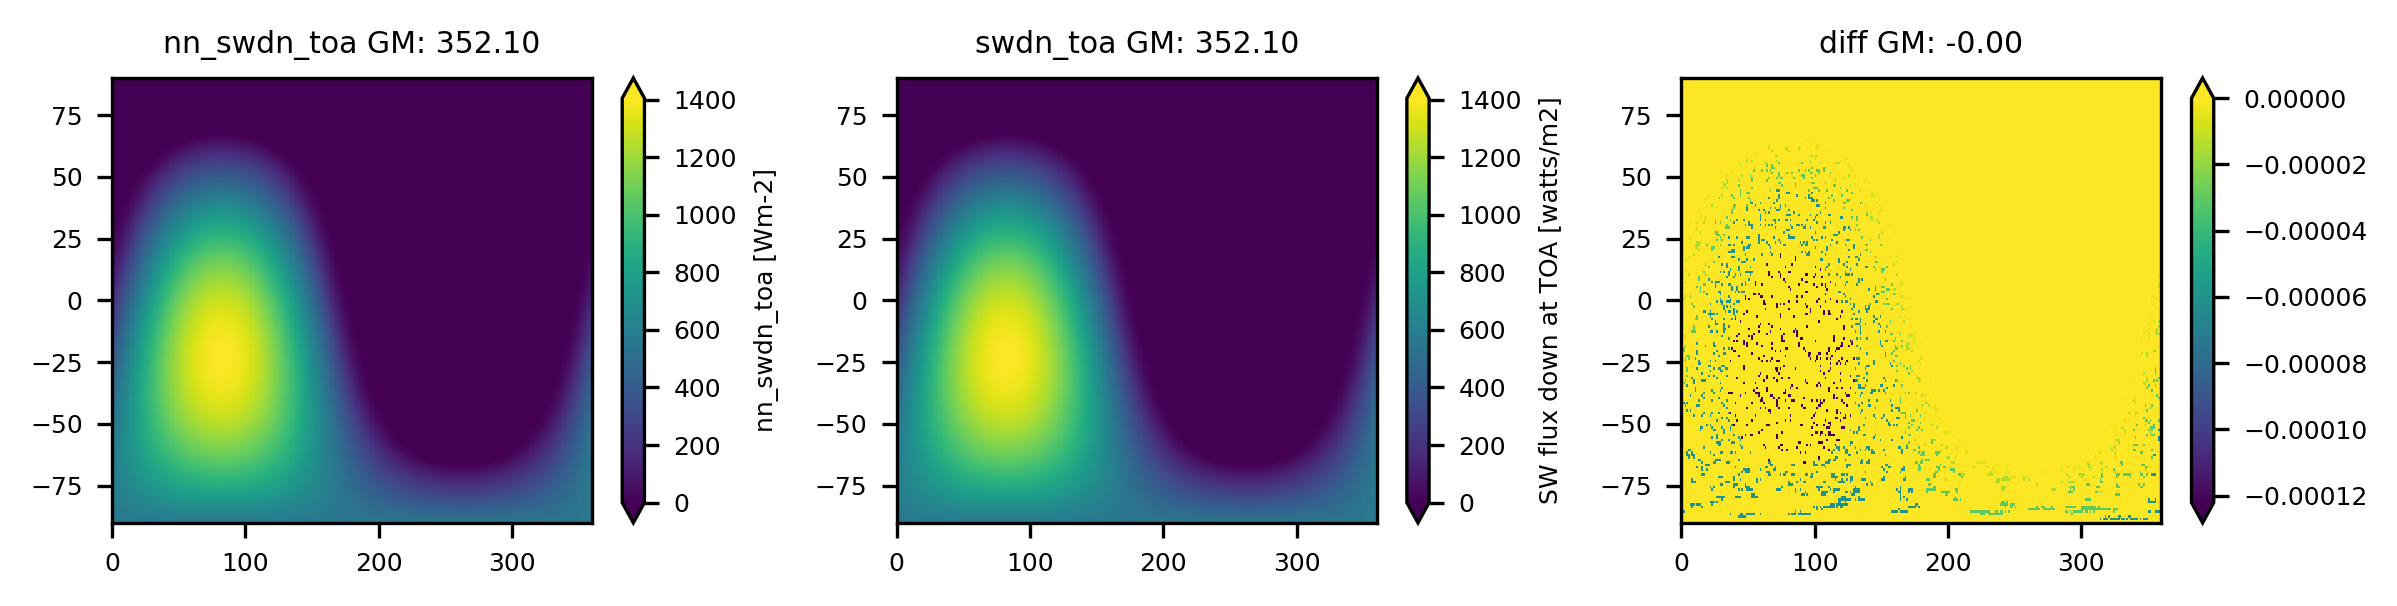

In [8]:
def plot_var12_diff2(var1,ds_sel):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=300)
    axs = axs.flatten()
    # level = np.arange(0,1400,10)
    for i in range(2):
        ax=axs[i]
        da = ds_sel[var1[i]]
        da.plot(ax=ax, extend='both') 
        # ax.set_title(f'{var1[i]} GM: {da.mean().values:4.2f}')
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    # level = np.arange(-1000,1000,2)
    da = (ds_sel[var1[0]]-ds_sel[var1[1]])
    da.plot(ax=ax, extend='both') 
    ax.set_title(f'diff GM: {da.mean().values:4.2f}')  
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()   
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=1) 
var = ['nn_swdn_toa','swdn_toa',]
plot_var12_diff2(var,ds_sel)  

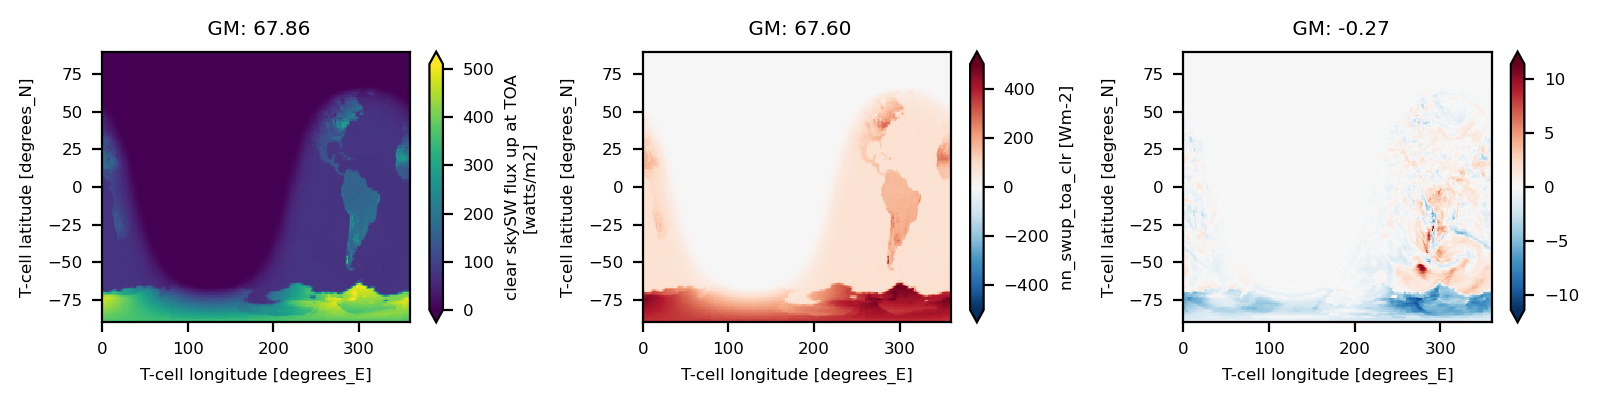

In [9]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
axs = axs.flatten()
# level = np.arange(0,1400,10)
itime = 4
da_list = [ ds['swup_toa_clr'][itime],
            ds['nn_swup_toa_clr'][itime],] 
da_list.append(da_list[1]-da_list[0])
for i in range(3):
    ax=axs[i]
    da = da_list[i]
    da.plot(ax=ax, extend='both') 
    ax.set_title(f' GM: {da.mean().values:4.2f}')   
fig.tight_layout()  
fig.show()

# Diff in rsdt

2000-01-01 12:00:00


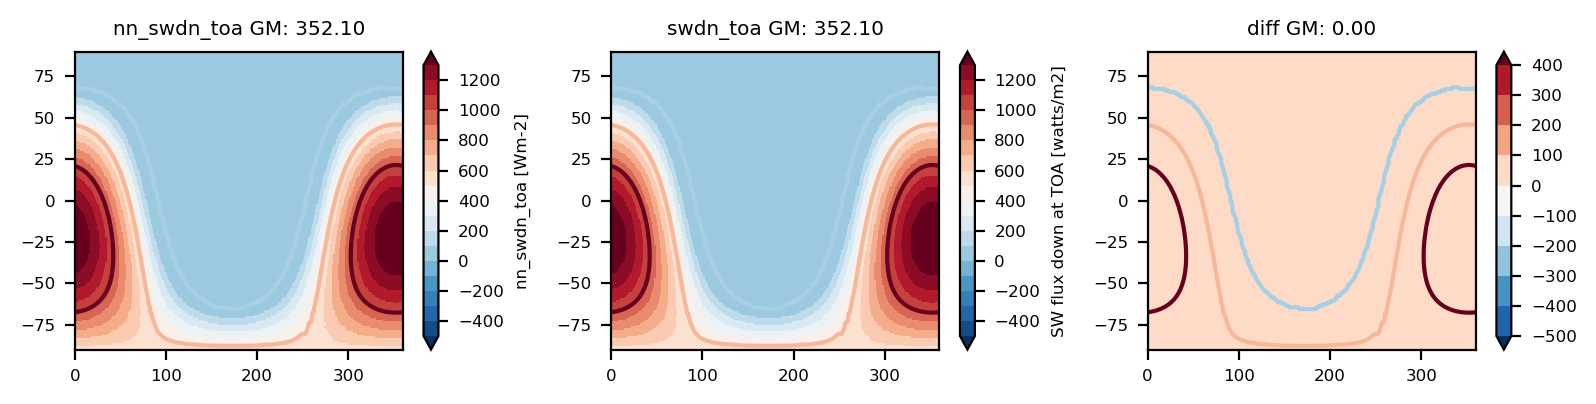

In [10]:
def plot_var12_diff2(var1,ds_sel,level1=np.arange(-500,1400,100),level2=np.arange(-500,500,100)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten() 
    for i in range(3): 
        ax=axs[i] 
        da = ds_sel[var1[0]]
        da.plot.contour(ax=ax, levels=np.arange(-500,1400,500)) 
    for i in range(2):
        ax=axs[i]
        da = ds_sel[var1[i]]
        da.plot(ax=ax, levels=level1, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    level = level2
    da = (ds_sel[var1[1]]-ds_sel[var1[0]])
    da.plot(ax=ax, levels=level2, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()   
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=3) 
print(ds_sel.time.data)
var = ['nn_swdn_toa','swdn_toa',]
plot_var12_diff2(var,ds_sel)   

# 

# Check Error in Energe conservation

## lw

In [11]:

hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values
B_k = hybrid_p_sigma_para.bk.values 
def energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps):
    C_p = 1004.64    # J/kg/K 
    g   = 9.8        # m/s^2  
    k = tdt_lw.shape[0]
    nlat = ps.shape[0] 
    P_lev = A_k[:,None,None] + np.matmul(B_k[:,None],ps.reshape(1,-1)).reshape(k+1,nlat,-1)
    dP = (P_lev[1:,:,:] - P_lev[:33,:,:])
    F_net = rlus - rlut - rlds 
    sum_Cphr_gdp = C_p/g * (tdt_lw*dP).sum(axis=0)
    E_err = F_net - sum_Cphr_gdp
    return E_err
def energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps):
    C_p = 1004.64    # J/kg/K 
    g   = 9.8        # m/s^2  
    k = tdt_lw.shape[0]
    nlat = ps.shape[0] 
    P_lev = A_k[:,None,None] + np.matmul(B_k[:,None],ps.reshape(1,-1)).reshape(k+1,nlat,-1)
    dP = (P_lev[1:,:,:] - P_lev[:33,:,:])
    F_net = rsdt - rsut + rsus - rsds 
    sum_Cphr_gdp = C_p/g * (tdt_sw*dP).sum(axis=0)
    E_err = F_net - sum_Cphr_gdp
    return E_err

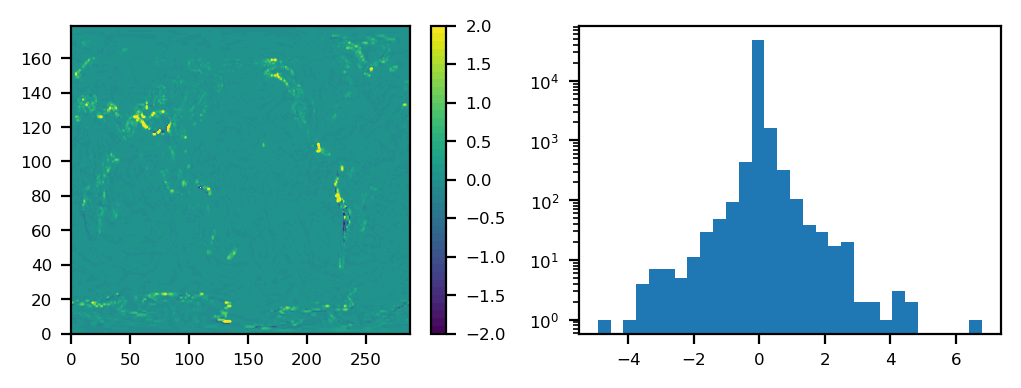

In [12]:
ds_sel = ds.isel(time=[0,1,2,3,4,5,6]).mean('time')
ds_sel = ds.isel(time=[4]).mean('time')
rlut = ds_sel['olr'].values
rlus = ds_sel['lwup_sfc'].values
rlds = ds_sel['lwdn_sfc'].values
tdt_lw = ds_sel['tdt_lw'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

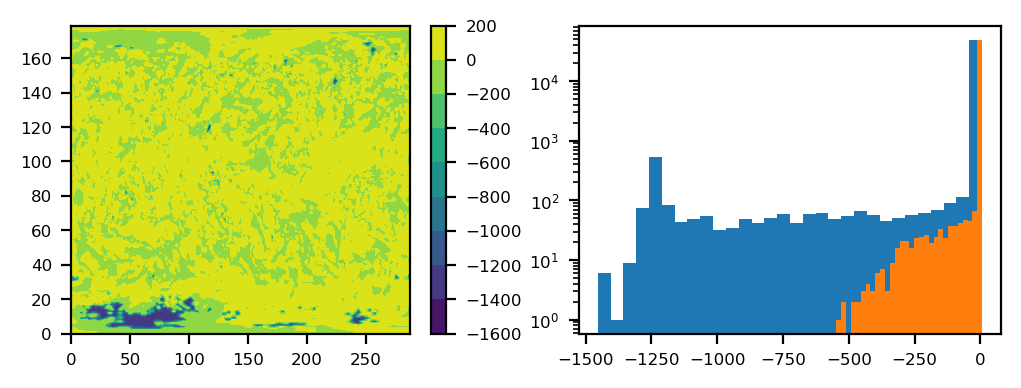

In [13]:
ds_sel = ds.isel(time=[0,1]).mean('time')
ds_sel = ds.isel(time=[0]).mean('time')
skycond = '_clr'
skycond = ''
rlut = ds_sel['nn_olr'+skycond].values
rlus = ds_sel['nn_lwup_sfc'].values
rlds = ds_sel['nn_lwdn_sfc'+skycond].values
tdt_lw = ds_sel['nn_tdt_lw'+skycond].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err )
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
ind = np.argwhere(rlus.flatten()>-100)
axs[1].hist(eng_err.flatten()[ind],bins=30)
axs[1].set_yscale('log')
fig.show()

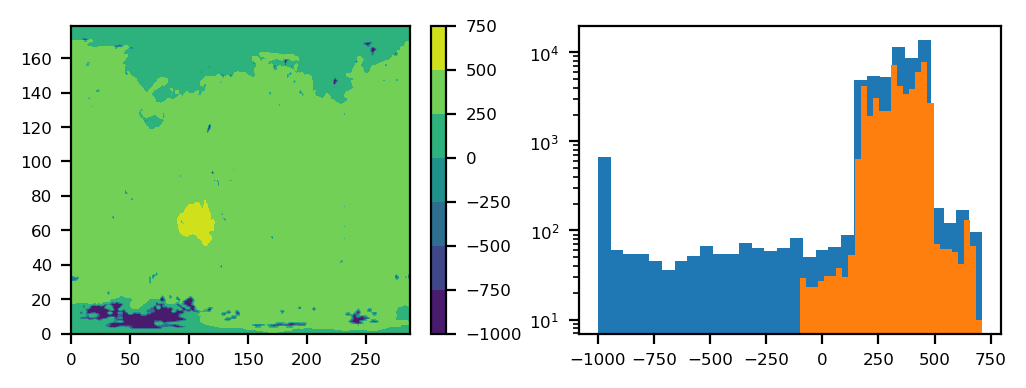

In [14]:
ds_sel = ds.isel(time=[0,1]).mean('time')
ds_sel = ds.isel(time=[0]).mean('time') 
rlus = ds_sel['nn_lwup_sfc'].values  
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(rlus ) 
fig.colorbar(h, ax=axs[0])
axs[1].hist(rlus.flatten(),bins=30)
axs[1].set_yscale('log')
ind = np.argwhere(rlus.flatten()>-100)
axs[1].hist(rlus.flatten()[ind],bins=30)
axs[1].set_yscale('log')
fig.show()

##  sw

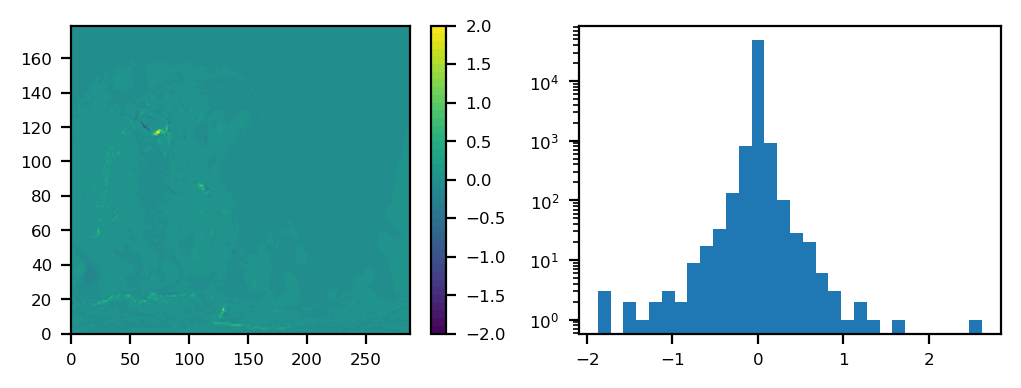

In [15]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rsut = ds_sel['swup_toa'].values
rsdt = ds_sel['swdn_toa'].values
rsus = ds_sel['swup_sfc'].values
rsds = ds_sel['swdn_sfc'].values
tdt_sw = ds_sel['tdt_sw'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

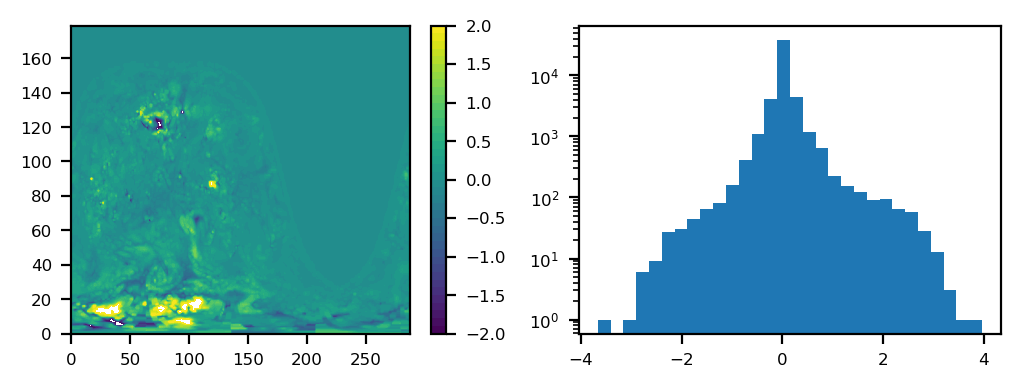

In [16]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rsut = ds_sel['nn_swup_toa'].values
rsdt = ds_sel['nn_swdn_toa'].values
rsus = ds_sel['nn_swup_sfc'].values
rsds = ds_sel['nn_swdn_sfc'].values
tdt_sw = ds_sel['nn_tdt_sw'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

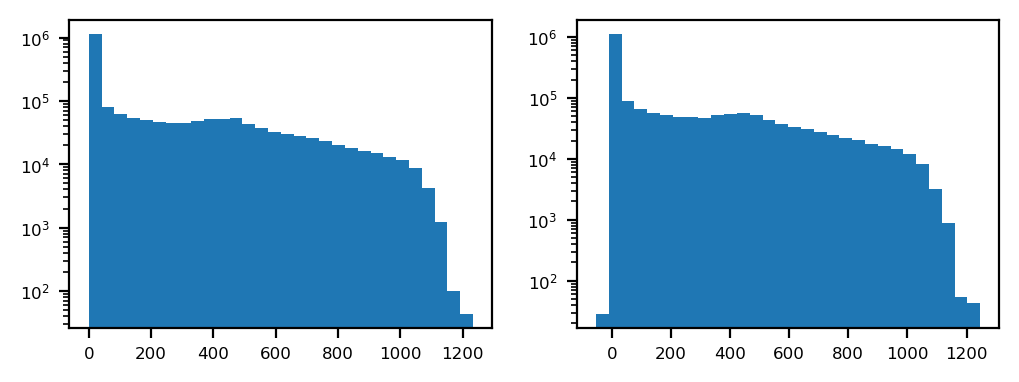

In [17]:
ds_sel = ds

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
data = ds_sel['swdn_sfc'].values
axs[0].hist(data.flatten(),bins=30)
axs[0].set_yscale('log')
data = ds_sel['nn_swdn_sfc'].values
axs[1].hist(data.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

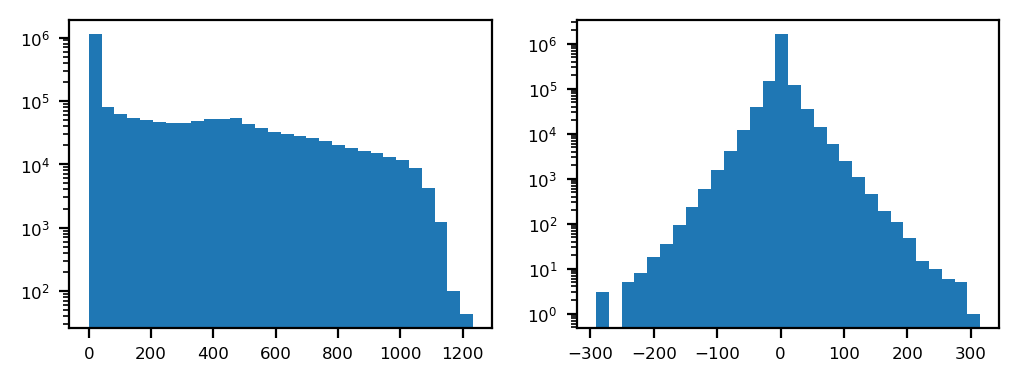

In [18]:
ds_sel = ds

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
data = ds_sel['swdn_sfc'].values
axs[0].hist(data.flatten(),bins=30)
axs[0].set_yscale('log')
data = ds_sel['nn_swdn_sfc'].values - ds_sel['swdn_sfc'].values
axs[1].hist(data.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

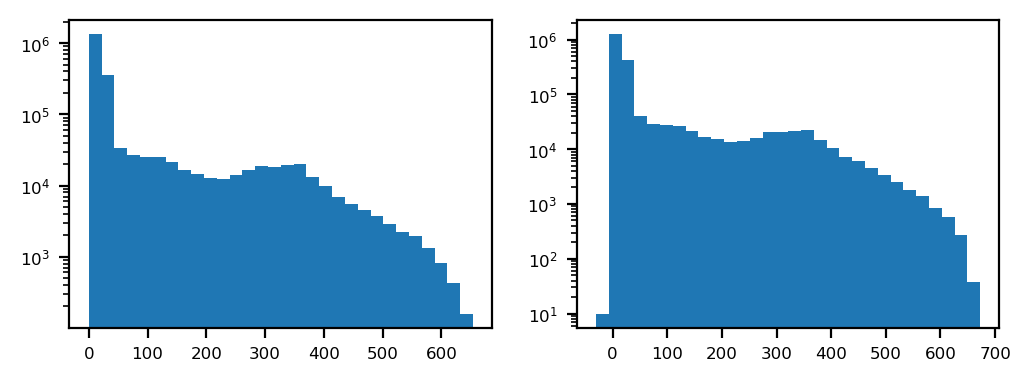

In [19]:
ds_sel = ds

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
data = ds_sel['swup_sfc'].values
axs[0].hist(data.flatten(),bins=30)
axs[0].set_yscale('log')
data = ds_sel['nn_swup_sfc'].values
axs[1].hist(data.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

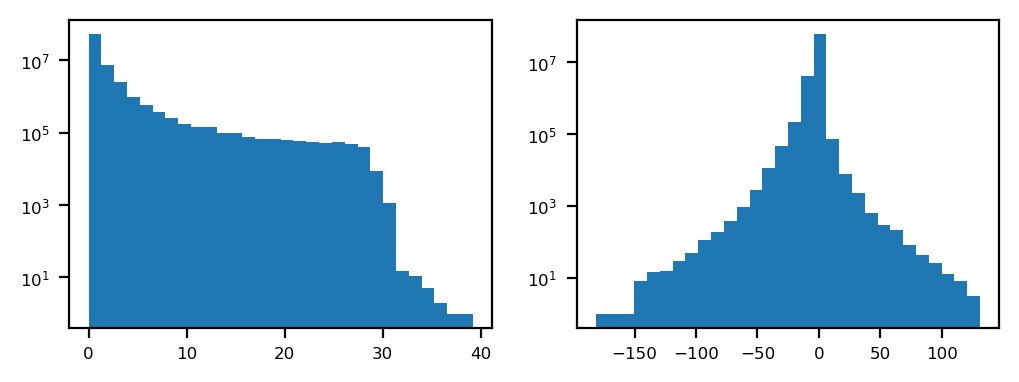

In [20]:
ds_sel = ds

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
data = ds_sel['tdt_sw'].values*86400
axs[0].hist(data.flatten(),bins=30)
axs[0].set_yscale('log')
data = ds_sel['tdt_lw'].values*86400
axs[1].hist(data.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

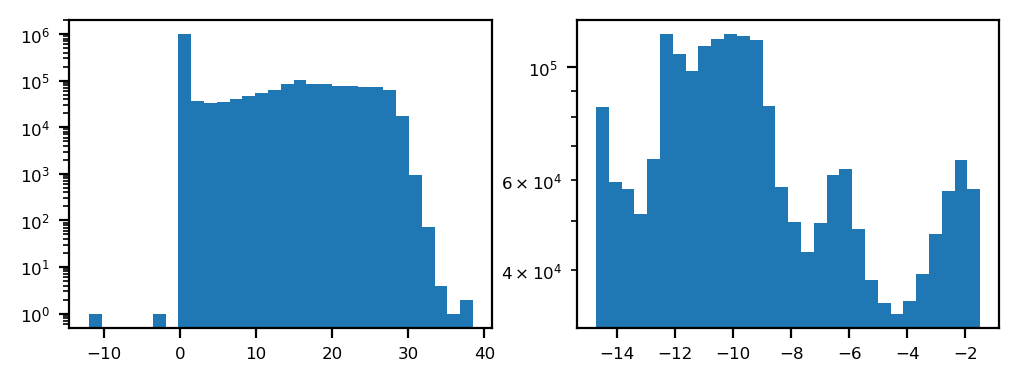

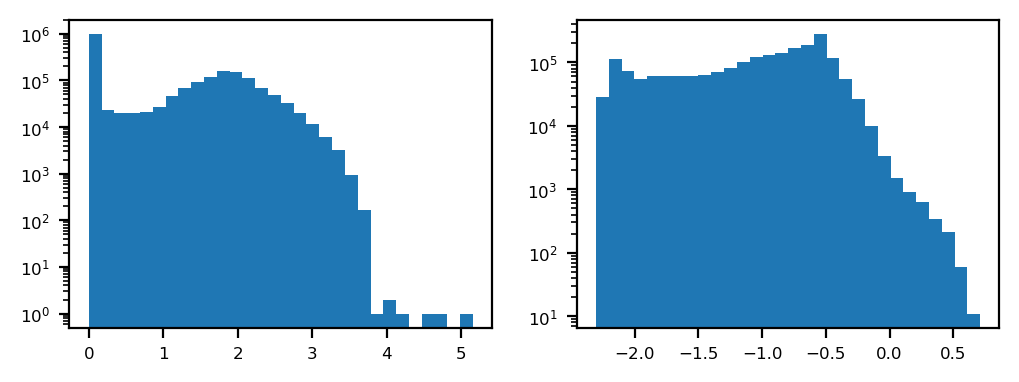

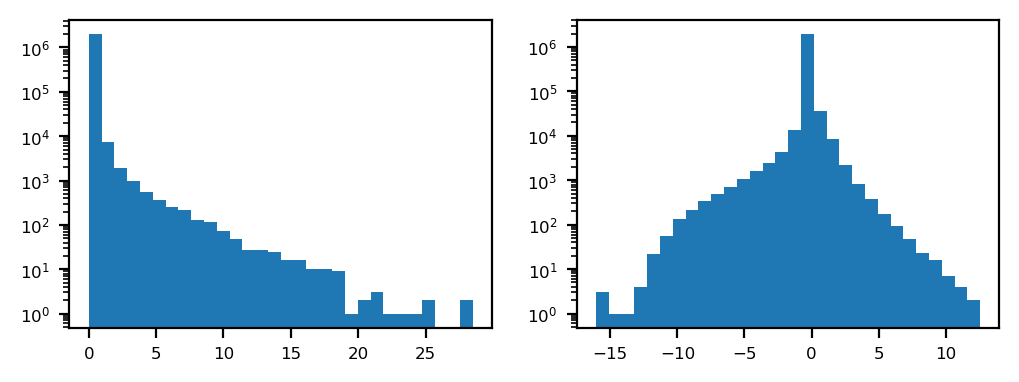

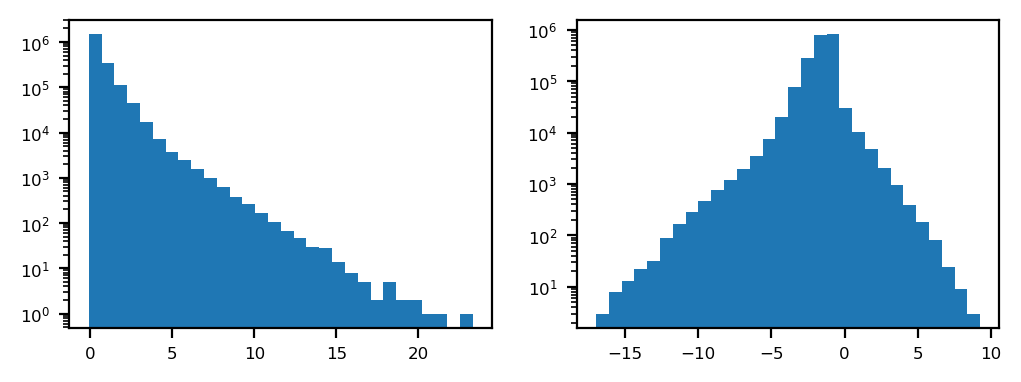

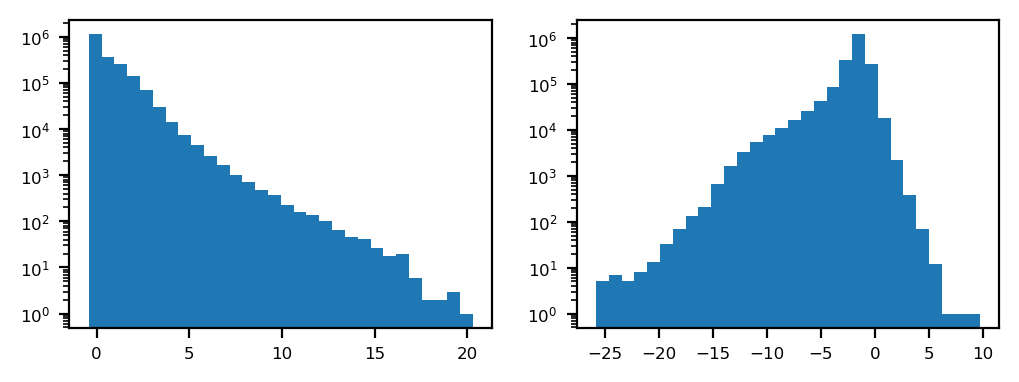

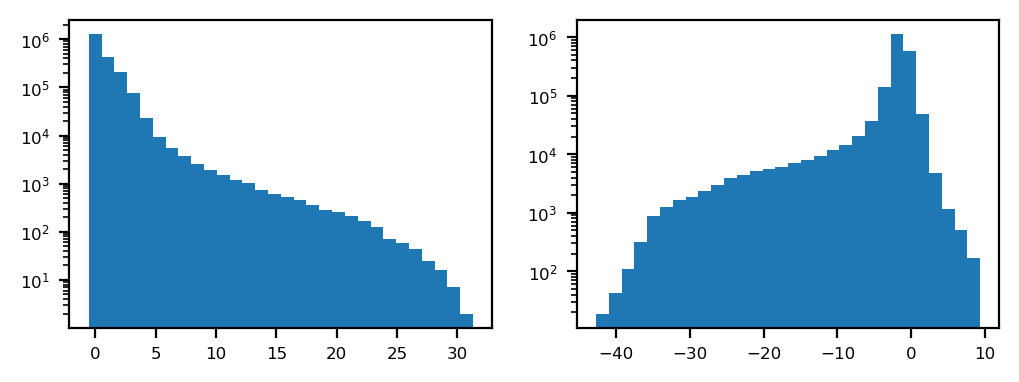

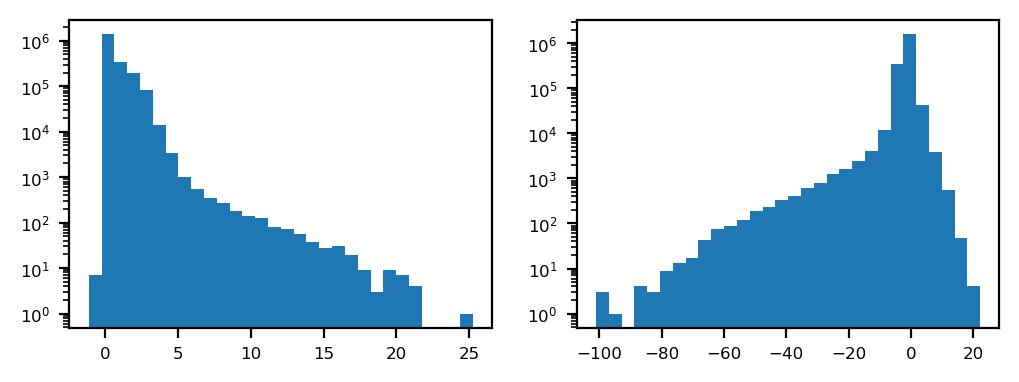

In [21]:
ds_sel = ds
for k in range(0,33,5):
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
    axs = axs.flatten()
    data = ds_sel['nn_tdt_sw'][:,k,:,:].values*86400
    axs[0].hist(data.flatten(),bins=30)
    axs[0].set_yscale('log')
    data = ds_sel['nn_tdt_lw'][:,k,:,:].values*86400
    axs[1].hist(data.flatten(),bins=30)
    axs[1].set_yscale('log')
    fig.show()

27.197048719972372
75.26253685355186
25.430944841355085
119.95191425085068
13.069205917418003
77.56756357848644
125.77824555337429
67.92401801794767
33.238350693136454
89.21784237027168
28.330851159989834
58.27953703701496


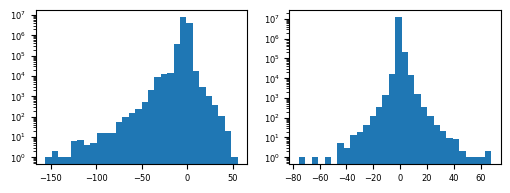

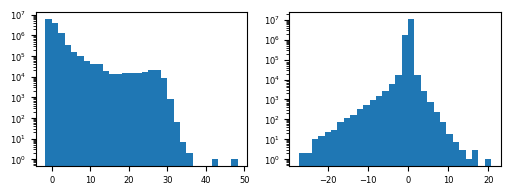

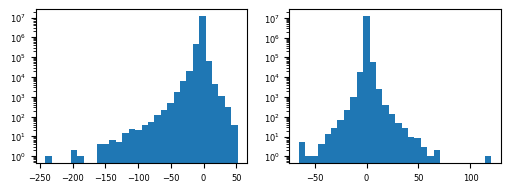

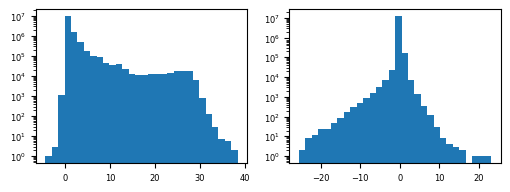

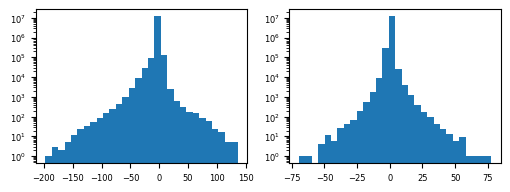

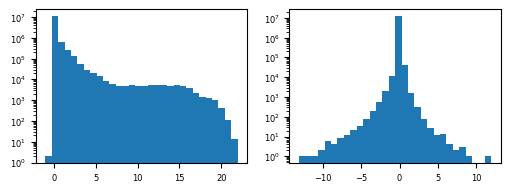

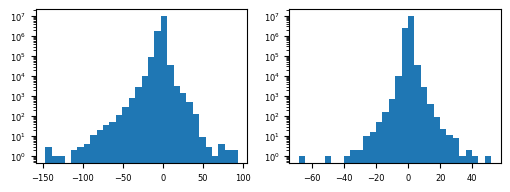

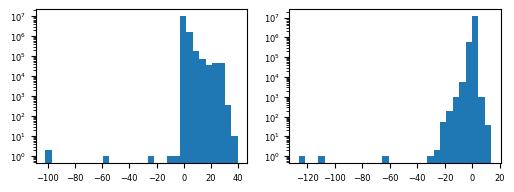

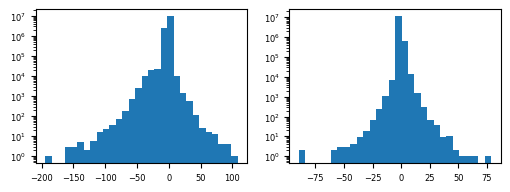

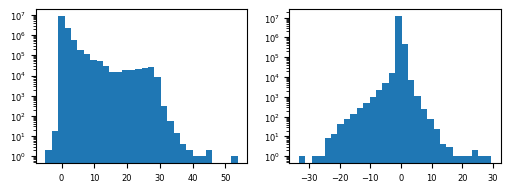

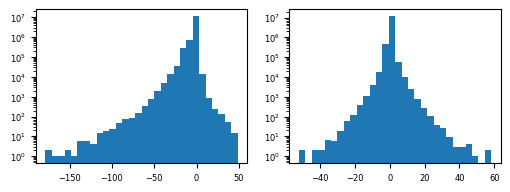

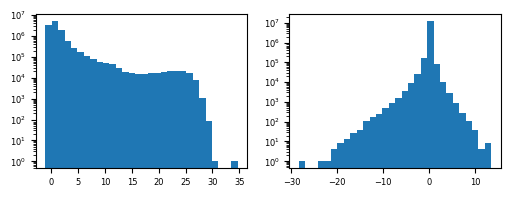

In [22]:

skycond = '_clr'
skycond = ''
for fi in range(1,7):
    ds = xr.open_dataset(file_path+f'/HISTORY/20000101.atmos_8xdaily.tile{fi}.nc')  
    # ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

    ds_sel = ds

    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=100)
    axs = axs.flatten()
    data = ds_sel['nn_tdt_lw'+skycond].values
    axs[0].hist(data.flatten()*86400,bins=30)
    axs[0].set_yscale('log')
    data = ds_sel['nn_tdt_lw'+skycond].values-ds_sel['tdt_lw'+skycond].values
    axs[1].hist(data.flatten()*86400,bins=30)
    axs[1].set_yscale('log')
    fig.show() 
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=100)
    axs = axs.flatten()
    data = ds_sel['nn_tdt_sw'+skycond].values
    axs[0].hist(data.flatten()*86400,bins=30)
    axs[0].set_yscale('log')
    data = ds_sel['nn_tdt_sw'+skycond].values-ds_sel['tdt_sw'+skycond].values
    axs[1].hist(data.flatten()*86400,bins=30)
    axs[1].set_yscale('log')
    fig.show()

    data = ds_sel['nn_tdt_sw'+skycond].values-ds_sel['tdt_sw'+skycond].values
    print(np.max(np.abs(data*86400)))

    data = ds_sel['nn_tdt_lw'+skycond].values-ds_sel['tdt_lw'+skycond].values
    print(np.max(np.abs(data*86400)))

# nn ratio

In [33]:
 
for fi in range(1,7):
    ds = xr.open_dataset(file_path+f'/HISTORY/20000101.atmos_8xdaily.tile{fi}.nc')  
    # ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

    ds_sel = ds
    data = ds_sel['nn_lwup_sfc'].values
    tmp = np.where(data<50, 1, 0 )
    print(np.sum(tmp), data.size, f'{np.sum(tmp)/data.size*100:5.2f}%')

ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 
ds_sel = ds
data = ds_sel['nn_lwup_sfc'].values
tmp = np.where(data<50, 1, 0 )
print(np.sum(tmp), data.size, f'{np.sum(tmp)/data.size*100:5.2f}%')

451 368640  0.12%
716 368640  0.19%
1047 368640  0.28%
754 368640  0.20%
578 368640  0.16%
6493 368640  1.76%
50561 2073600  2.44%
